This notebook collects algorithms for evolving or evaluating (in nonprecessing cases) the orbital evolution of the PN system.  The primary approximants are denoted TaylorT$n$ for $n \in [1,5]$.  "Taylor" means that they are Taylor series (as opposed to Padé), "T" means that they are in the time domain (as opposed to frequency), and $n$ just numbers the order in which they were established in the literature.  The other important approximant is TaylorF2, which is based on TaylorT2, but is in the frequency domain.

In [1]:
# Always run this first
# NOTE: Do not define new basic variables in this notebook;
#       define them in Variables_Q.ipynb.  Use this notebook
#       to define new expressions built from those variables.

import sympy
from sympy import *
from __future__ import division # This needs to be here, even though it's in Variables_Q.ipynb
import sys
sys.path.insert(0, '..') # Look for modules in directory above this one
import pickle
execfile('../Utilities/ExecNotebook.ipy')
try:
    UseQuaternions
    VariablesNotebook = 'Variables_Q.ipynb' if UseQuaternions else 'Variables_Q.ipynb'
except:
    UseQuaternions = False
    VariablesNotebook = 'Variables_Q.ipynb'
execnotebook(VariablesNotebook)
from Utilities import CodeOutput

/home/dongze/.local/lib/python3.8/site-packages/IPython/nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "
/home/dongze/.local/lib/python3.8/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


Here, we set the PN order, if it is not already set.  This will be used in numerous places below.  This is the exponent of the largest power of $x$, or half the exponent of the largest power of $v$ that will appear beyond leading orders in the various quantities.  Note that, because of python's convention that intervals are half-open at the end, most occurrences of `PNOrbitalEvolutionOrder` in the code will have 1 added to them; the actual value of `PNOrbitalEvolutionOrder` will be what we normally expect.

In [2]:
if 'PNOrbitalEvolutionOrder' not in globals():
    PNOrbitalEvolutionOrder = frac(7,2)

# TaylorT1, TaylorT4, and TaylorT5*

These very similar approximants are the simplest in construction, and most widely applicable.  In particular, they can both be applied to precessing systems.  Each gives rise to the same system of ODEs that need to be integrated in time, except that the right-hand side for $dv/dt$ is expanded as a series in $v$ and truncated for TaylorT4.  TaylorT5 extends that simply.


***** The version of TaylorT5 output below is slightly different from the one introduced by Ajith.  He further solved analytically for the orbital phase $\Phi$ in terms of $v$.  This doesn't appear to be possible in the precessing case, since terms such as $\vec{\Sigma} \cdot \hat{L}_{\text{N}}$ now vary with $v$ in nontrivial ways; I believe uses of T5 for precessing systems assume that such terms are constant.  Besides, we have 11 variables to integrate in addition to $\Phi$, so it's not much extra burden to integrate it too.  For nonprecessing systems, similar code could be generated for the non-precessing case using Ajith's solution for $\Phi$; the value of `y[1]` would have to be reset explicitly at the top of the `TaylorT4RHS` function emitted below.

First, we collect the various expressions from other notebooks:

In [3]:
execnotebook('BindingEnergy.ipynb')
execnotebook('EnergyAbsorption.ipynb')
execnotebook('Precession.ipynb')

Next, we calculate the expansions needed for TaylorT4 and T5.  These will be the right-hand sides in our evolution equations for $dv/dt$.  TaylorT1 simply numerically evaluates a ratio of the terms imported above

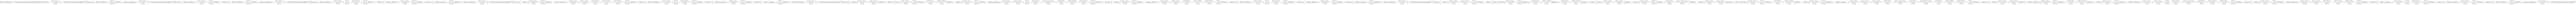

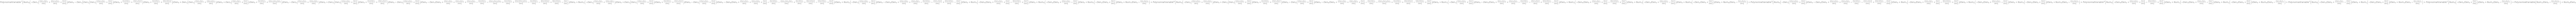

In [4]:
# Read in the high-order series expansion of a ratio of polynomials
with open('PolynomialRatios/PolynomialRatioSeries_Order{0}.dat'.format(2*PNOrbitalEvolutionOrder+1), 'rb') as fff:
    p_Ratio = pickle.load(fff)
#display(p_Ratio)
p_Ratio = (p_Ratio.removeO()).subs('PolynomialVariable',v)
#display(p_Ratio)

#p_Ratio = pickle.load(file('PolynomialRatios/PolynomialRatioSeries_Order{0}.dat'.format(2*PNOrbitalEvolutionOrder+1)))
#p_Ratio = p_Ratio.removeO().subs('PolynomialVariable',v)

# Evaluate the flux, energy, and derivative of energy
FluxTerms = [Flux_NoSpin, Flux_Spin]
BindingEnergyTerms = [BindingEnergy_NoSpin, BindingEnergy_Spin]
for Term in FluxTerms:
    PNVariables.update(Term)
for Term in BindingEnergyTerms:
    PNVariables.update(Term)
Flux = FluxExpression(FluxTerms, PNOrbitalEvolutionOrder)
Energy = BindingEnergyExpression(BindingEnergyTerms, PNOrbitalEvolutionOrder)
dEdV = BindingEnergyDerivativeExpression(BindingEnergyTerms, PNOrbitalEvolutionOrder)

# Evaluate the energy absorption by the BHs, and make substitutions so that the Horner form is nice
AbsorptionTerms = [AlviTerms]
for Term in AbsorptionTerms:
    PNVariables.update(Term)
Absorption = AbsorptionExpression(AbsorptionTerms, PNOrbitalEvolutionOrder)

# Treat remaining log(v) terms as constants, for Taylor expansions and efficient numerical evaluation
Flux = Flux.subs(log(v), logv)
Energy = Energy.subs(log(v), logv)
dEdV = dEdV.subs(log(v), logv)
Absorption = Absorption.subs(log(v), logv)

# Get the series expansions for the numerators and denominators
FluxSeries = series(- (Flux + Absorption)/Fcal_coeff, x=v, x0=0, n=2*PNOrbitalEvolutionOrder+1).removeO()
dEdVSeries = series(dEdV/(-nu*v/2), x=v, x0=0, n=2*PNOrbitalEvolutionOrder+1).removeO()

# TaylorT4
T4Expressions = PNCollection()
NumTerms4 = {'Num{0}'.format(n): FluxSeries.coeff(v,n=n) for n in range(2*PNOrbitalEvolutionOrder+1)}
DenTerms4 = {'Den{0}'.format(n): dEdVSeries.coeff(v,n=n) for n in range(2*PNOrbitalEvolutionOrder+1)}
T4Expressions.AddDerivedConstant('dvdt_T4', (Fcal_coeff/(-nu*v/2))*\
    horner(sum([v**n*horner(N(p_Ratio.coeff(v,n=n).subs(dict(NumTerms4.items() | DenTerms4.items()))))
                for n in range(2*PNOrbitalEvolutionOrder+1)])))

# TaylorT5
T5Expressions = PNCollection()
NumTerms5 = {'Num{0}'.format(n): dEdVSeries.coeff(v,n=n) for n in range(2*PNOrbitalEvolutionOrder+1)}
DenTerms5 = {'Den{0}'.format(n): FluxSeries.coeff(v,n=n) for n in range(2*PNOrbitalEvolutionOrder+1)}
T5Expressions.AddDerivedConstant('dtdv', ((-nu*v/2)/Fcal_coeff)*\
    horner(sum([v**n*horner(N(p_Ratio.coeff(v,n=n).subs(dict(NumTerms5.items() | DenTerms5.items()))))
                for n in range(2*PNOrbitalEvolutionOrder+1)])))
T5Expressions.AddDerivedConstant('dvdt_T5', 1.0/dtdv)

# TaylorT1 just gets some substitutions for efficiency
T1Expressions = PNCollection()
T1Expressions.AddDerivedConstant('Flux', Flux.subs(Pow(nu,3), nu__3).subs(Pow(nu,2), nu__2))
T1Expressions.AddDerivedConstant('dEdV', dEdV.subs(Pow(nu,3), nu__3).subs(Pow(nu,2), nu__2))
T1Expressions.AddDerivedConstant('Absorption', Absorption.subs(Pow(nu,3), nu__3).subs(Pow(nu,2), nu__2))
T1Expressions.AddDerivedConstant('dvdt_T1', - (Flux + Absorption) / dEdV)

Now, the precession terms:

In [5]:
PrecessionVelocities = PNCollection()

PrecessionVelocities.AddDerivedVariable('OmegaVec_chiVec_1',
                                        Precession_chiVec1Expression(PNOrbitalEvolutionOrder),
                                        datatype=ellHat.datatype)
PrecessionVelocities.AddDerivedVariable('OmegaVec_chiVec_2',
                                        Precession_chiVec2Expression(PNOrbitalEvolutionOrder),
                                        datatype=ellHat.datatype)
PrecessionVelocities.AddDerivedVariable(('OmegaVec' if UseQuaternions else 'OmegaVec_ellHat'),
                                        Precession_ellHatExpression(PNOrbitalEvolutionOrder)*nHat
                                        + ((v**3/M)*ellHat if UseQuaternions else 0),
                                        datatype=nHat.datatype)

In [6]:
CodeConstructor = CodeOutput.CodeConstructor(PNVariables, T1Expressions)
for Terms in BindingEnergyTerms+FluxTerms+[AlviTerms]+[Precession_ellHat, Precession_chiVec1, Precession_chiVec2]:
    CodeConstructor.AddDependencies(Terms)
CodeConstructor.AddDependencies(PrecessionVelocities)

# TaylorT2 and TaylorT3

These two approximants are also closely related to each other.  I believe they are only possible for nonprecessing systems, without further assumptions about the constancy of certain projections of the spins.  I choose not to make those assumptions.

# TaylorF2

Being based on the `TaylorT2` approximant, I think this approximant is only possible for nonprecessing systems without further assumptions.